This project uses data related to the Electric Production from 1985 to 2017 and aims to develop ML algorithms for prediction and forecasting (SARIMAX and LSTM)<br>

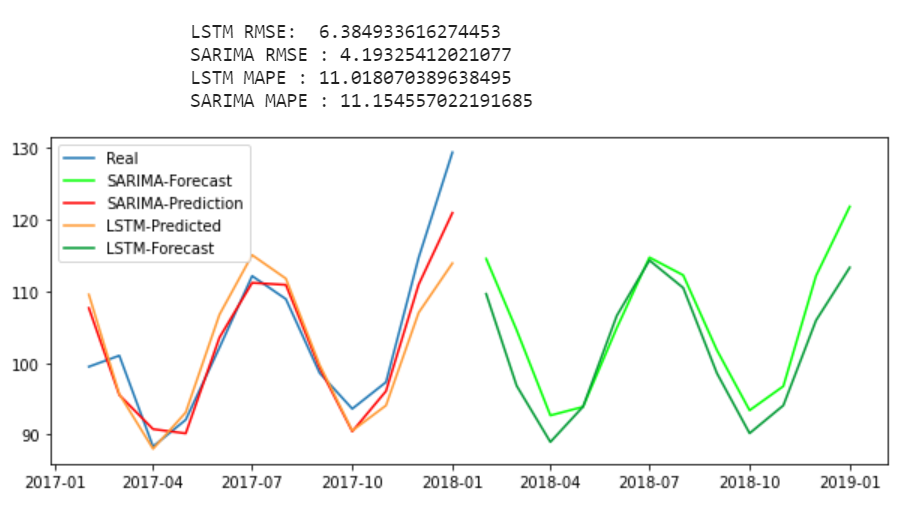
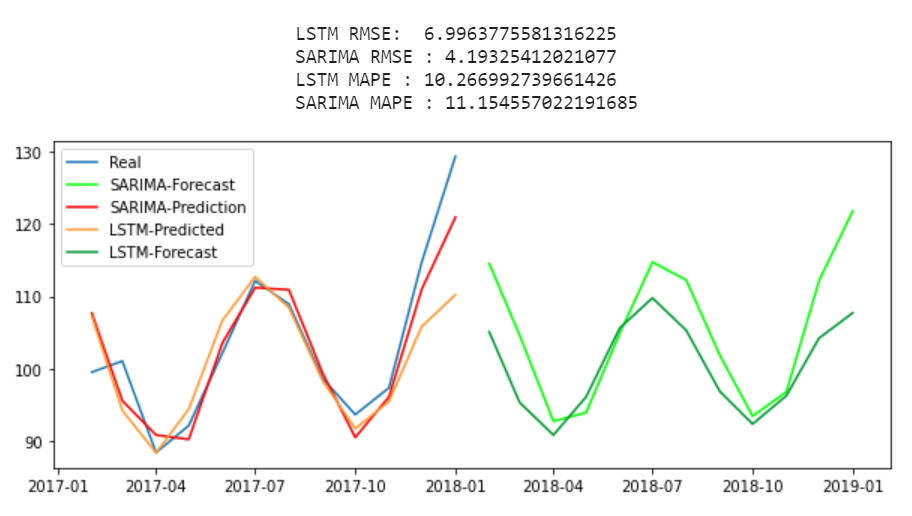

The results look indeed very similar both in terms of rmse and mape.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('Electric_Production.csv', index_col='DATE', parse_dates=True)

In [4]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
df.columns = ['value']

In [6]:
df.tail()

,value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


There are no missing values!

<AxesSubplot:xlabel='DATE'>

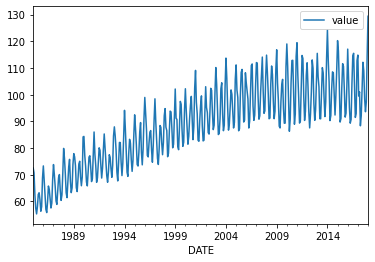

In [8]:
df.plot()

The data can be interpreted as a time series with a clear positive trend and seasonality.<br>
In the following, aprediction model by LSTM RNN and SARIMAX will be developed to forecast the time series.

# LSTM RNN model


When modeling a time series by LSTM RNN, it is crucial to to properly shape the input data in a sliding windows format.

First, we need to specify the prediciton window. In this application, the data is given as monthly data. So, for example, we can use a 12 steps prediction window. This means that we use 12 samples of data (data of an entire year) to predict the 13th sample.

In [9]:
prediction_windows=12

Now we can split the data into a train and test set. In particular, this means that the train set will have 397-12=385 samples, while the test set only the last 12 values.

In [75]:
train=df.iloc[:len(df)-prediction_windows]
test=df.iloc[len(df)-prediction_windows:]

In the following, since we will use a RNN, it is recommended to rescale the data.

In [76]:
from sklearn.preprocessing import MinMaxScaler

In [77]:
scaler=MinMaxScaler()

In [78]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [79]:
n_input=12 #Use 12 months data to predict 13 th month data
n_features=1 # we are dealing with an univariate time series, so n_features should be set to 1. 
#In case of a multivariate time series, n_features should be set to a proper value higher than 1.

Now we can formally create the train set. As stated before, the train set will have a "sliding window" shape. This means that we have to shape the data in such a way that the RNN will predict the 13th sample starting from the previous from 12 samples.

In [115]:
X_train=[]
y_train=[]
for i in range(n_input,len(scaled_train)):
    X_train.append(scaled_train[i-n_input:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [116]:
print(f'Given the Array: \n {X_train[0].flatten()}')
print(f'Predict this value: \n {y_train[0]}')

Given the Array: 
 [0.24934943 0.22275812 0.10349754 0.03127801 0.         0.04025686
 0.10596346 0.11507721 0.07643625 0.01450976 0.03895283 0.19436378]
Predict this value: 
 [0.26096101]


In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [161]:
# define model
model = Sequential()
model.add(LSTM(100, input_shape=(n_input, n_features), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(20, input_shape=(n_input, n_features), return_sequences=False))
#model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [162]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12, 100)           40800     
_________________________________________________________________
lstm_10 (LSTM)               (None, 20)                9680      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 50,501
Trainable params: 50,501
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
12/12 [==============================] - 4s 16ms/step - loss: 0.1930
Epoch 2/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0311
Epoch 3/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0181
Epoch 4/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0153
Epoch 5/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0143
Epoch 6/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0139
Epoch 7/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0130
Epoch 8/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0139
Epoch 9/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0131
Epoch 10/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0128
Epoch 11/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0131
Epoch 12/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0133
Epoch 13/100
12/12 [=====

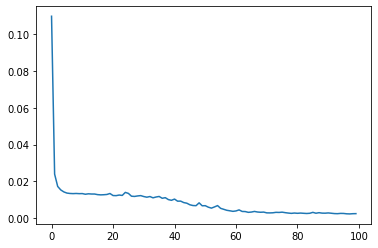

In [164]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# LSTM Prediction

In [165]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(test)):
    #get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [166]:
true_predictions = scaler.inverse_transform(test_predictions)

In [167]:
test['Predictions'] = true_predictions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

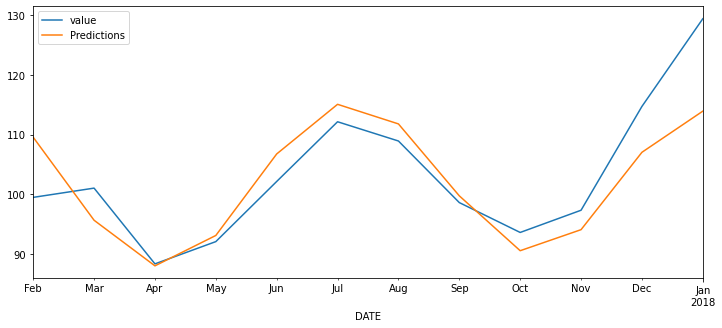

In [168]:
test.plot(figsize=(12,5))

In [169]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_lstm=sqrt(mean_squared_error(test['value'],test['Predictions']))
print(rmse_lstm)

6.384933616274453


In [170]:
pred_dates=np.asarray(test.index)
dates=np.asarray(df.index)

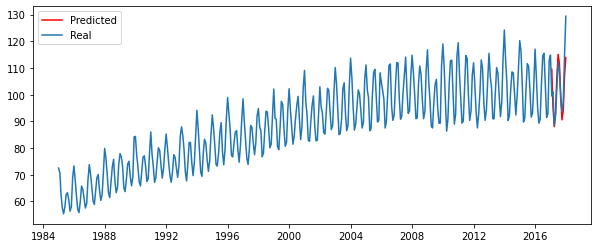

In [171]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(dates,df.values, label='Real')
plt.legend()
plt.show()

To check the performance of the algorithm, we will also define a MAPE (Mean absolute percentage error) function that returns the MAPE.

In [172]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [173]:
mape_lstm=mape(df.values[-12:], test['Predictions'].values)
mape_lstm

11.018070389638495

# LSTM FORECAST

We can use the developed LSTM RNN to forecast the data. <br>
First, we need to create a new vector with the indeces of the forecast days. In this case, we choose to forecast the data for 12 months.

In [174]:
date_offset=12
forecast_dates =  (df.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [175]:
forecast=[]

first_eval_batch = test_predictions[-n_input:] #use the past 12 values of the predicted values to forecast
current_batch=np.reshape(first_eval_batch,(1,n_input,n_features))

for i in range(date_offset):
    #get the prediction alue for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    forecast.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [176]:
true_forecast= scaler.inverse_transform(forecast)

In [177]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['forecast']=true_forecast
df_forecast.head()

,forecast
date,
2018-02-01,109.652404
2018-03-01,96.832080
2018-04-01,88.980635
2018-05-01,93.910680
2018-06-01,106.609871


<AxesSubplot:xlabel='date'>

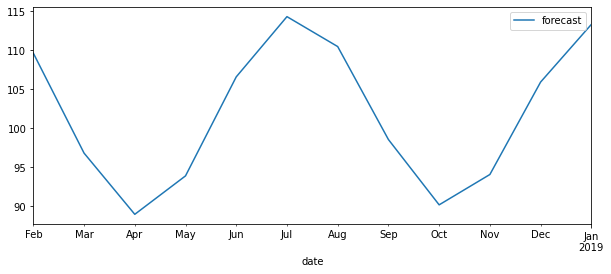

In [178]:
df_forecast.plot(figsize=(10,4))

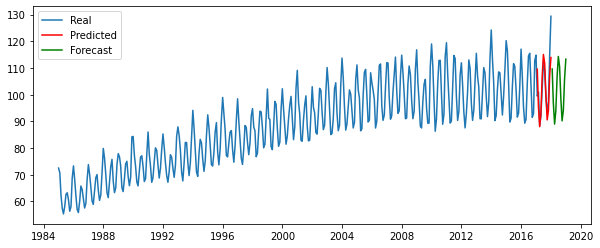

In [179]:
plt.figure(figsize=(10,4))
plt.plot(dates,df.values, label='Real')
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='green', label='Forecast')
plt.legend()
plt.show()

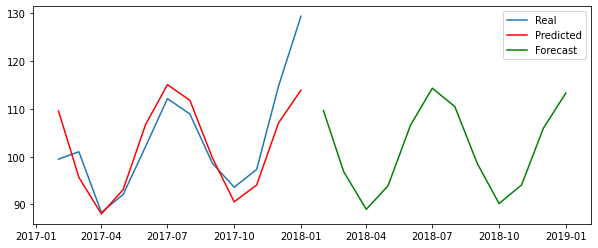

In [180]:
plt.figure(figsize=(10,4))
plt.plot(dates[-12:],df[-12:].values, label='Real')
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='green', label='Forecast')
plt.legend()
plt.show()

# SARIMA model

In the following,the time series will be modeled by as a SARIMA model.

We can use some useful tools such as 'seasonal decompose' to better visualize the time series.

<Figure size 432x288 with 0 Axes>

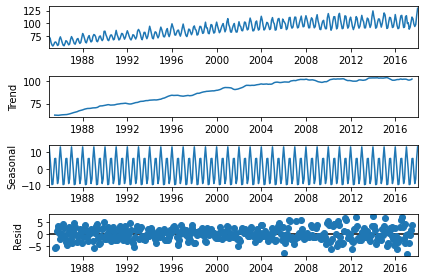

In [181]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df)

fig = plt.figure()  
fig = result.plot()

We can also check the stationarity of the time serie by performing the Augmented Dickey Fuller (ADF) test.

In [182]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df.value.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-2.2569903500472366
p-value:0.18621469116587053


The p-value is higher than 0.05. This means that the time serie is non stationary with a confidence of 95%. We check if with a one step differentiation, the time serie become stationary (in terms of a trendless time series).

In [183]:
result=adfuller(df.value.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-7.104890882267309
p-value:4.0777865655394705e-10


Now the series looks stationary with a 1-order difference

## ACF AND PACF

In [184]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

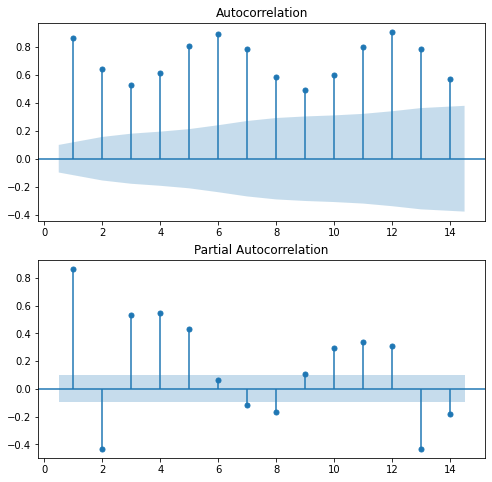

In [185]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df,lags=14, zero=False, ax=ax1)
plot_pacf(df,lags=14, zero=False, ax=ax2)
plt.show()

The series looks indeed non stationary

## AUTO ARIMA

In [186]:
!pip install pmdarima
import pmdarima as pm

In [187]:
results=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1912.925, Time=0.76 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2404.500, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1998.731, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2057.803, Time=0.31 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2000.250, Time=0.58 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1880.044, Time=1.20 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=2.75 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=2.12 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=1925.181, Time=0.80 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=1942.791, Time=0.68 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=1881.313, Time=1.85 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=1880.682, Time=1.54 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=1955.485, T

In [188]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 2, 6))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62107D+00    |proj g|=  1.35732D-01


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.31439D+00    |proj g|=  2.99144D-02

At iterate   10    f=  2.28953D+00    |proj g|=  1.30022D-02

At iterate   15    f=  2.26953D+00    |proj g|=  3.67458D-02

At iterate   20    f=  2.26706D+00    |proj g|=  4.60416D-03

At iterate   25    f=  2.26588D+00    |proj g|=  1.02781D-02

At iterate   30    f=  2.26473D+00    |proj g|=  1.20999D-03

At iterate   35    f=  2.26471D+00    |proj g|=  5.25788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     46      1     0     0   3.090D-05   2.265D+00
  F =   2.2647070235339561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [189]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                  397
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                -899.089
Date:                           Sun, 19 Sep 2021   AIC                           1814.177
Time:                                   12:30:05   BIC                           1845.907
Sample:                               01-01-1985   HQIC                          1826.755
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0873      0.350     -0.249      0.803      -0.773       0.599
ar.L2          0.2828      0.214      1.321      0.187      -0.137       0.702
ma.L1         -0.2982      0.337     -0.884      0.377      -0.959       0.363
ma.L2         -0.6397      0.329     -1.944      0.052      -1.285       0.005
ar.S.L6       -0.9976      0.003   -380.207      0.000      -1.003      -0.992
ma.S.L6        0.1145      0.040      2.832      0.005       0.035       0.194
ma.S.L12      -0.7764      0.037    -20.853      0.000      -0.849      -0.703
sigma2         5.5549      0.307     18.092      0.000       4.953       6.157
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


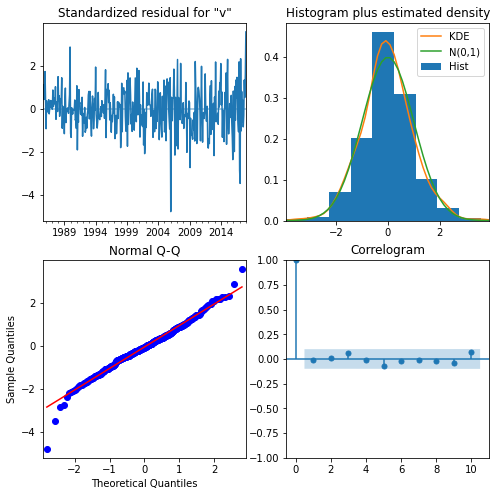

In [190]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

All the 4 plots indicates a good fit of the SARIMA model on the given time serie.

# SARIMA PREDICTION

Now we will create a vector that will host the predictions

In [191]:
prediction = results.get_prediction(start=-12)
mean_prediction=prediction.predicted_mean

Moreover, we also get the confidence intervals from the sarima prediction

In [192]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

In [193]:
pred_dates=np.asarray(mean_prediction.index)
dates=np.asarray(df.index)

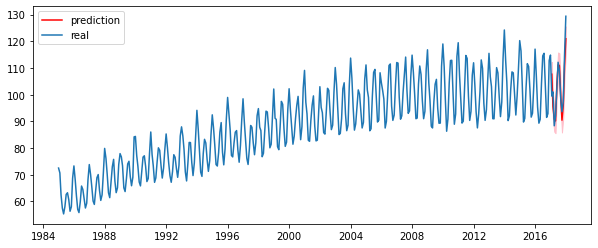

In [194]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,mean_prediction.values,color='red',label='prediction')
plt.fill_between(pred_dates, lower_limits_p, upper_limits_p, color='pink')
plt.plot(dates,df.values, label='real')
plt.legend()
plt.show()

In [195]:
mape_sarima = mape(df[-12:].values,mean_prediction.values)

In [196]:
rmse_sarima = sqrt(mean_squared_error(df[-12:].values,mean_prediction.values))
print(rmse_sarima)

4.19325412021077


# SARIMA FORECAST

In [197]:
# Make ARIMA forecast of next 10 values
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast.size

12

In [198]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

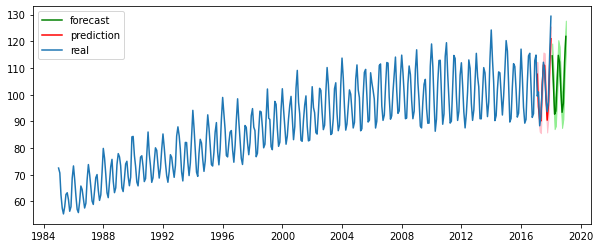

In [199]:
forec_dates=np.asarray(mean_forecast.index)
pred_dates=np.asarray(mean_prediction.index)
dates=np.asarray(df.index)
plt.figure(figsize=(10,4))
plt.plot(forec_dates,mean_forecast.values,color='green',label='forecast')
plt.fill_between(forec_dates, lower_limits_f, upper_limits_f, color='lightgreen')

plt.plot(pred_dates,mean_prediction.values,color='red',label='prediction')
plt.fill_between(pred_dates, lower_limits_p, upper_limits_p, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()

# Results Sumamry

In [200]:
print('LSTM RMSE: ', rmse_lstm)
print('SARIMA RMSE :', rmse_sarima)
print('LSTM MAPE :', mape_lstm)
print('SARIMA MAPE :', mape_sarima)

LSTM RMSE:  6.384933616274453
SARIMA RMSE : 4.19325412021077
LSTM MAPE : 11.018070389638495
SARIMA MAPE : 11.154557022191685


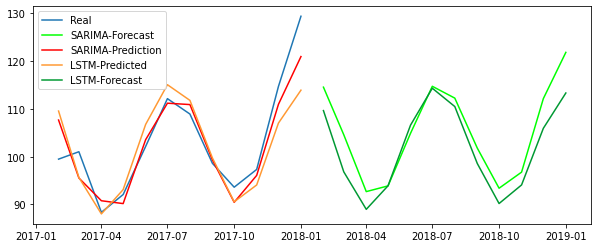

In [201]:
plt.figure(figsize=(10,4))
plt.plot(dates[-12:],df[-12:].values, label='Real') 
plt.plot(forec_dates,mean_forecast.values,color='#00ff00',label='SARIMA-Forecast')
plt.plot(pred_dates,mean_prediction.values,color='#ff0000',label='SARIMA-Prediction')
plt.plot(pred_dates,test['Predictions'].values,color='#ff9933',label='LSTM-Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='#009933', label='LSTM-Forecast')
plt.legend(loc='upper left')
plt.show()